In [135]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
from datasets import load_dataset
import torchvision
from torchvision import transforms
import numpy as np


In [136]:
### Hyperparams 
batch_size = 64
num_workers = 4
validation_ratio = 0.2

In [137]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])


In [138]:
path = r'C:\python\datasets_storage'
test_data = torchvision.datasets.CIFAR100(root=path,train=False,download=True, transform=transform)
dataset_train = torchvision.datasets.CIFAR100(root=path,train=True,download=True, transform=transform)

train_data,validation_data=torch.utils.data.random_split(dataset_train,[int((1-validation_ratio)*len(dataset_train)), int((validation_ratio)*len(dataset_train))])
print(len(validation_data))
print(len(train_data))

Files already downloaded and verified
Files already downloaded and verified
10000
40000


In [139]:
train_loader = DataLoader(train_data, batch_size=batch_size, pin_memory=True, shuffle=True)
val_loader = DataLoader(validation_data, batch_size=batch_size, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size,shuffle=True, pin_memory=True)

In [140]:
def check_device():
    if torch.cuda.is_available:
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def move_device(tensor,device):
    if isinstance(tensor,(list,tuple)):    
      return[move_device(element,device) for element in tensor]  
    return tensor.to(device,non_blocking=True)
class DeviceDataloader():
    def __init__(self,dataloader,device):
        self.dataloader = dataloader
        self.device = device
    def __iter__(self):
        # transfer ecach batch and return
        for i in self.dataloader:
           yield move_device(i, self.device)
    def __len__(self):

        return len(self.dataloader)
device = check_device()

train_dl = DeviceDataloader(train_loader, device)
test_dl = DeviceDataloader(test_loader, device)
val_dl  = DeviceDataloader(val_loader, device)
#len(train_dl)

In [141]:
class CNN_model(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(CNN_model,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32), # out channels, helps normalize batches and imporves overall better performance
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2),
            nn.Dropout(dropout_rate)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2),
            nn.Dropout(dropout_rate)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            nn.Dropout(dropout_rate)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            nn.Dropout(dropout_rate)
        )
        self.hidden_layer = nn.Linear(256 * 2 * 2, 512)
        self.output_layer = nn.Linear(512, 100)
    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.conv4(output)
        #flattening 
        output = output.view(-1, 256 * 2 * 2)
        # fully connected layers
        output = self.hidden_layer(output)
        output = self.output_layer(output)
        return output
model = CNN_model()
print(model)

CNN_model(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  

In [142]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
#optimizer = optim.SGD(model.parameters(), lr= 3e-3, momentum=0.9)
optimizer = optim.AdamW(model.parameters(), lr=3e-3)

In [143]:
print(torch.cuda.is_available())
print(torch.version.cuda if torch.cuda.is_available() else "CUDA not found")

True
12.1


In [144]:
print('Starting...')
epochs = 40
model = model.to(device)
def model_train(model, train_loader, criterion, optimizer):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for batch_idx,(images,targets) in enumerate(train_loader):
            optimizer.zero_grad()
            images,targets = images.to(device), targets.to(device)
            outputs = model(images)
            
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item() ### compares predicted lables to true lables and returns True/False
            batch_idx += 1
        
            if batch_idx % 100 == 0:
                print(f'Epoch" {epoch + 1}/{epochs} | Loss:{running_loss} | '
                      f'Loss: {running_loss / (batch_idx+1):.4f} | '
                      f'Acc_train: {100.*correct/total:.2f}% | '
                      f'Batch: {batch_idx / len(train_loader)}')
def model_val(model, val_loader):
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        for images, targets in val_loader:
            with torch.no_grad():
                images,targets = images.to(device), targets.to(device)
                outputs = model(images)
    
                loss = criterion(outputs, targets)
    
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                return val_loss/len(val_loader), 100.* correct/total
        print('Finished!')

Starting...


In [145]:
model_train(model,train_loader, criterion, optimizer)
val_loss, val_acc = model_val(model, val_loader)

Epoch" 1/40 | Loss:532.0793266296387 | Loss: 5.2681 | Acc_train: 1.91% | Batch: 0.16
Epoch" 1/40 | Loss:980.4672708511353 | Loss: 4.8779 | Acc_train: 2.73% | Batch: 0.32
Epoch" 1/40 | Loss:1410.6894493103027 | Loss: 4.6867 | Acc_train: 3.38% | Batch: 0.48
Epoch" 1/40 | Loss:1830.2410144805908 | Loss: 4.5642 | Acc_train: 4.04% | Batch: 0.64
Epoch" 1/40 | Loss:2239.796248435974 | Loss: 4.4707 | Acc_train: 4.93% | Batch: 0.8
Epoch" 1/40 | Loss:2641.279309988022 | Loss: 4.3948 | Acc_train: 5.77% | Batch: 0.96
Epoch" 2/40 | Loss:390.18987679481506 | Loss: 3.8633 | Acc_train: 12.62% | Batch: 0.16
Epoch" 2/40 | Loss:779.2073669433594 | Loss: 3.8767 | Acc_train: 12.85% | Batch: 0.32
Epoch" 2/40 | Loss:1161.9605360031128 | Loss: 3.8603 | Acc_train: 13.33% | Batch: 0.48
Epoch" 2/40 | Loss:1543.0162997245789 | Loss: 3.8479 | Acc_train: 13.54% | Batch: 0.64
Epoch" 2/40 | Loss:1920.5884699821472 | Loss: 3.8335 | Acc_train: 13.90% | Batch: 0.8
Epoch" 2/40 | Loss:2292.458435535431 | Loss: 3.8144 | Ac

In [146]:
print(f'Val_loss: {val_loss:.4f}, Val_acc: {val_acc}%')

Val_loss: 0.0160, Val_acc: 56.25%


In [147]:
def model_test(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    for images, targets in test_loader:
        with torch.no_grad():
            images,targets = images.to(device), targets.to(device)
            outputs = model(images)

            loss = criterion(outputs, targets)
            test_loss += loss.item()

            _, predicted = outputs.max(1)
            total = predicted.size(0)
            correct = predicted.eq(targets).sum().item()
            return test_loss/len(test_loader), 100.*correct/total
test_loss,test_acc = model_test(model, test_loader)
print(f"test loss: {test_loss} | test acc: {test_acc}%")

test loss: 0.016217816407513467 | test acc: 48.4375%


In [148]:
# ------------- 5 epochs --------------- lr = 3e-3
#Acc_train: 26.01%. Val_acc: 28.125% test acc: 29.6875% - no weight_decay/ SGD opimizer
#Acc_train: 25.56%  Val_acc: 25.0%   test acc: 35.9375% - AdamW optimizer
#Acc_train: 25.09%  Val_acc: 25.0%   test acc: 32.8125% - AdamW with 1e-2 weight_decay
# ------------- 5 epochs --------------- lr = 3e-4
#Acc_train: 28.55%  Val_acc: 28.125% test acc: 23.4375%
# -------------- 40 epochs -------------- lr = 3e-3
#Acc_train: 41.29%  Val_acc: 56.25%   test acc: 48.4375% - AdamW

In [181]:
new_test_dataset = torchvision.datasets.CIFAR10(root=path, download=True,transform=transform)
new_test_loader = DataLoader(new_test_dataset, batch_size=32,pin_memory=True, shuffle = False)

Files already downloaded and verified


In [197]:
image, label = new_test_dataset[0]

In [198]:
import matplotlib.pyplot as plt
classes = new_test_dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

TypeError: Invalid shape (3, 32, 32) for image data

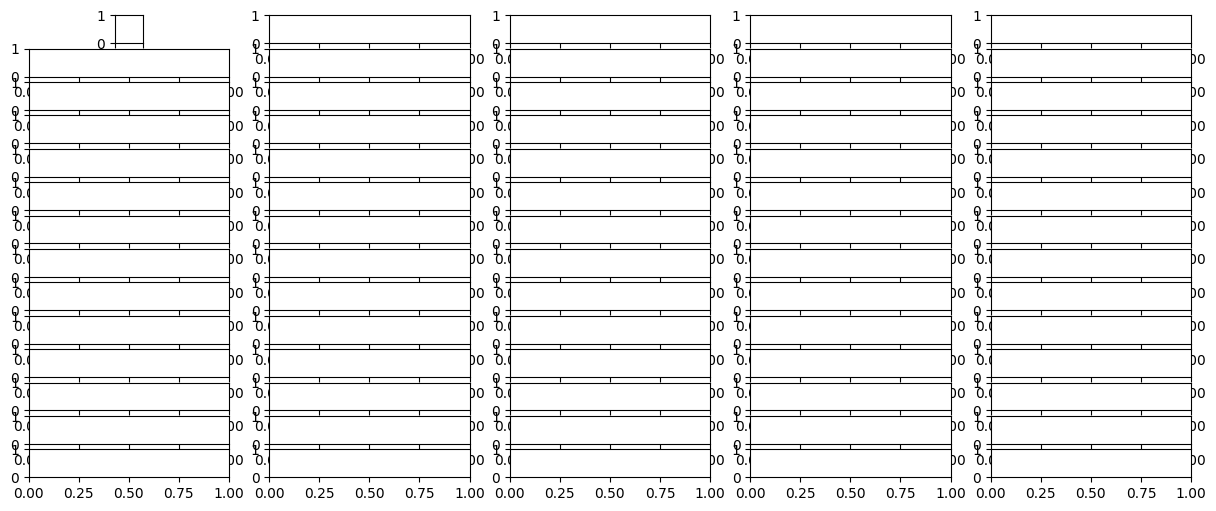

In [202]:
def display_image(datset, num_images = 10, cols = 5):
    rows = (num_images + cols - 1)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(num_images):
        image, label = new_test_dataset[i]
        axes[i].imshow(image)
        axes[i].set_title(f'{classes[label]}')
        axes[i].axis('off')
    for i in range(num_images, len(axes)):
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    
display_image(new_test_dataset, num_images=10, cols=5)